In [ ]:
# dataset @ https://finance.yahoo.com/quote/2222.SR/history?period1=1576022400&period2=1708560000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

## Import Pandas and Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('ARAMCO.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-11,29.090908,29.090908,29.090908,29.090908,25.618723,38289394
1,2019-12-12,31.983471,31.983471,29.752066,30.413223,26.783211,505692621
2,2019-12-15,30.661158,30.991735,30.413223,30.909090,27.219894,98349281
3,2019-12-16,30.991735,31.487602,30.991735,31.404959,27.656578,105973907
4,2019-12-17,31.446280,31.528925,30.991735,31.198347,27.474625,142672245
...,...,...,...,...,...,...,...
1046,2024-02-15,31.950001,32.299999,31.799999,31.950001,31.950001,22239458
1047,2024-02-18,31.900000,32.099998,31.850000,31.950001,31.950001,8742507
1048,2024-02-19,31.900000,32.000000,31.799999,31.950001,31.950001,12043315
1049,2024-02-20,31.950001,32.000000,31.549999,31.650000,31.650000,10781599


### Simplify Dataset
For this project, I will not use all the data from the dataset, and instead only consider the closing stock price for each day.

In [ ]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2019-12-11,29.090908
1,2019-12-12,30.413223
2,2019-12-15,30.909090
3,2019-12-16,31.404959
4,2019-12-17,31.198347
...,...,...
1046,2024-02-15,31.950001
1047,2024-02-18,31.950001
1048,2024-02-19,31.950001
1049,2024-02-20,31.650000


## Convert Date Data Type from String

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)


datetime_object = str_to_datetime('2019-12-11')
datetime_object

datetime.datetime(2019, 12, 11, 0, 0)

In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-5-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2019-12-11
1      2019-12-12
2      2019-12-15
3      2019-12-16
4      2019-12-17
          ...    
1046   2024-02-15
1047   2024-02-18
1048   2024-02-19
1049   2024-02-20
1050   2024-02-21
Name: Date, Length: 1051, dtype: datetime64[ns]

## Make Date Column the Index

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
2019-12-11,29.090908
2019-12-12,30.413223
2019-12-15,30.909090
2019-12-16,31.404959
2019-12-17,31.198347
...,...
2024-02-15,31.950001
2024-02-18,31.950001
2024-02-19,31.950001


## Import matplotlib and plot a visualization of the stock data

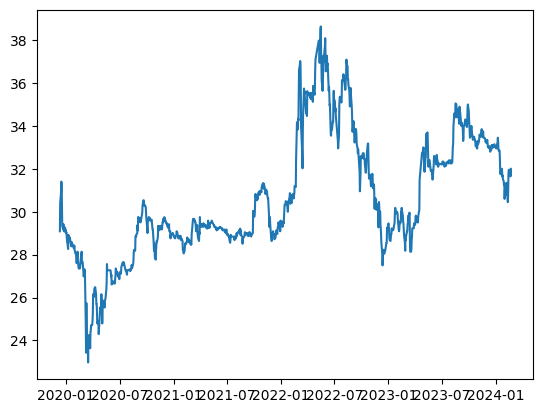

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

## Convert to Supervised problem
This is done so that I will be able to convert the data into numpy arrays that I can then feed into a Tensorflow model.

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df